The following sequence of code will prepare our data for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

## Collect and prepare data for analysis

In [2]:
df = pd.read_csv('TSLA.csv',  parse_dates=True)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df = df[['Close']]  # watch the spaces in the column name 

In [6]:
df

,Close
0,18.891333
1,18.897333
2,18.712667
3,19.032000
4,19.605333
...,...
1253,185.000000
1254,187.039993
1255,184.309998
1256,180.589996


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df[['Close']])

In [8]:
df['Close'].isna().sum()

0

In [9]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

1258

In [10]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(1258, 1)

In [11]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [12]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(1250, 1)

In [13]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[-1.06178894, -1.05620165, -1.05117078, ..., -1.05743041,
        -1.06194543, -1.06061236],
       [-1.06173677, -1.06621124, -1.06176576, ..., -1.06218886,
        -1.0575753 , -1.06162666],
       [-1.05751735, -1.05466574, -1.05791726, ..., -1.02798706,
        -1.0268221 , -1.01932215],
       ...,
       [ 0.27669447,  0.28121533,  0.29025693, ...,  0.36650244,
         0.49108601,  0.43518418],
       [ 0.44448671,  0.42875078,  0.44092219, ...,  0.46665618,
         0.44761652,  0.38623763],
       [ 0.38223838,  0.37745671,  0.39727878, ...,  0.37571796,
         0.34337664,  0.19036413]])

In [14]:
# we can now see that our days have been organized into rows of sequence length. 

In [15]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(87, 9, 1)
(38, 9, 1)


In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(120, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 120)               14640     
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________


In [19]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
3/3 [==============================] - 3s 428ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 2/600
3/3 [==============================] - 0s 33ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1450
Epoch 3/600
3/3 [==============================] - 0s 32ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 4/600
3/3 [==============================] - 0s 30ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1587
Epoch 5/600
3/3 [==============================] - 0s 38ms/step - loss: 0.0822 - root_mean_squared_error: 0.2868 - val_loss: 0.0818 - val_root_mean_squared_error: 0.2859
Epoch 6/600
3/3 [==============================] - 0s 47ms/step - loss: 0.0569 - root_mean_squared_error: 0.2385 - val_loss: 0.0117 - val_root_mean_s

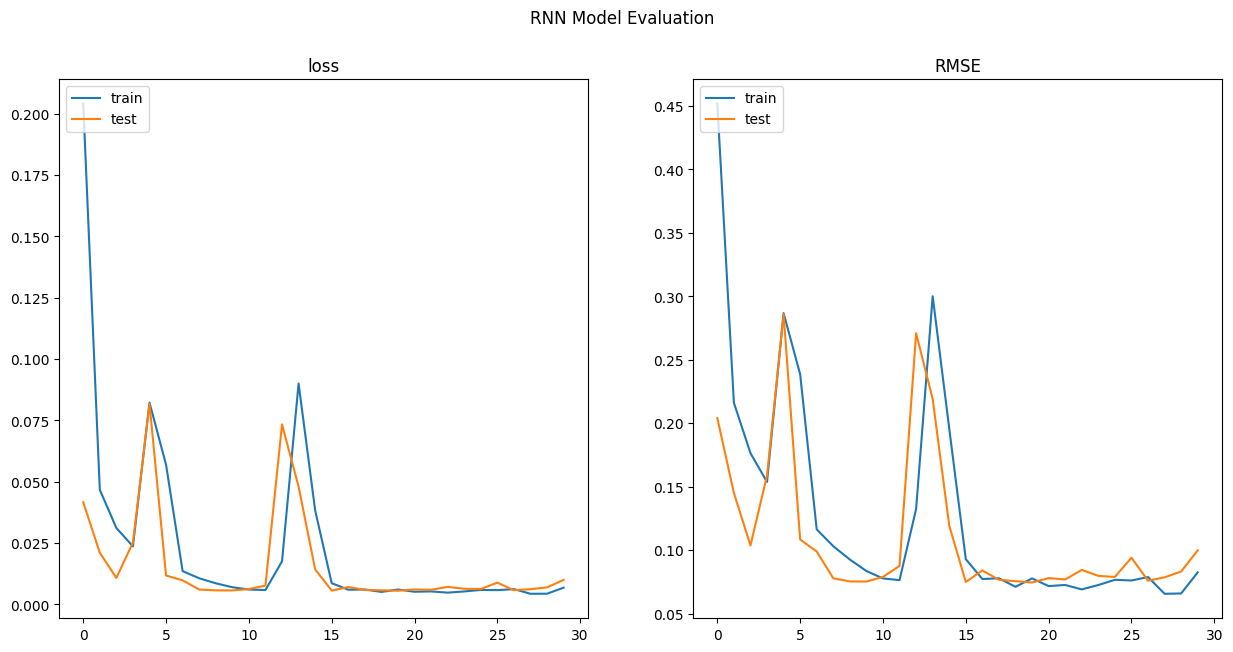

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [22]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


2/2 [==============================] - 0s 4ms/step


0.0997775642457222

In [23]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# A normal (cross-sectional) NN

In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 3ms/step - loss: 2.6625
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 2.3846
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 2.1252
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 1.8829
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 1.6603
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4699
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 1.3020
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 1.1437
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0128
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.8862
Epoch 11/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7882
Epoch 12/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6964
Epoch 13/100
3/3 [==============================] - 0s 2ms/st

In [25]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [26]:
mean_squared_error(y_test, y_pred)

0.009730191311546699

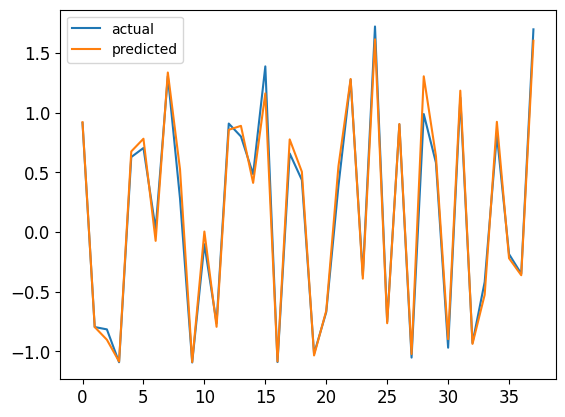

In [27]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

In [28]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 1s 8ms/step - loss: 1.1909
Epoch 2/30
3/3 [==============================] - 0s 41ms/step - loss: 1.0109
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 0.8536
Epoch 4/30
3/3 [==============================] - 0s 10ms/step - loss: 0.7086
Epoch 5/30
3/3 [==============================] - 0s 10ms/step - loss: 0.5911
Epoch 6/30
3/3 [==============================] - 0s 6ms/step - loss: 0.4889
Epoch 7/30
3/3 [==============================] - 0s 24ms/step - loss: 0.4039
Epoch 8/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3415
Epoch 9/30
3/3 [==============================] - 0s 33ms/step - loss: 0.2748
Epoch 10/30
3/3 [==============================] - 0s 98ms/step - loss: 0.2102
Epoch 11/30
3/3 [==============================] - 0s 29ms/step - loss: 0.1491
Epoch 12/30
3/3 [==============================] - 0s 6ms/step - loss: 0.1019
Epoch 13/30
3/3 [==============================] - 0s 5ms/step -

In [30]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [31]:
mean_squared_error(y_test, y_pred)

0.004643166419942821

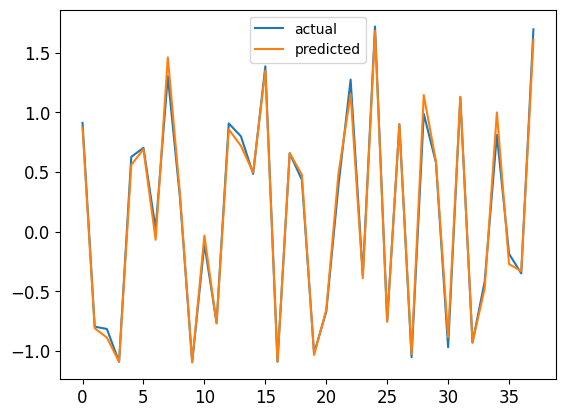

In [32]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# Simple RNN with more layers

In [33]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 2s 7ms/step - loss: 0.8223
Epoch 2/30
3/3 [==============================] - 0s 9ms/step - loss: 0.4852
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 0.2698
Epoch 4/30
3/3 [==============================] - 0s 9ms/step - loss: 0.1230
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0420
Epoch 6/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 7/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 8/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0380
Epoch 9/30
3/3 [==============================] - 0s 48ms/step - loss: 0.0280
Epoch 10/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0150
Epoch 11/30
3/3 [==============================] - 0s 17ms/step - loss: 0.0096
Epoch 12/30
3/3 [==============================] - 0s 12ms/step - loss: 0.0104
Epoch 13/30
3/3 [==============================] - 0s 22ms/step - lo

In [35]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [36]:
mean_squared_error(y_test, y_pred)

0.005570877804989163

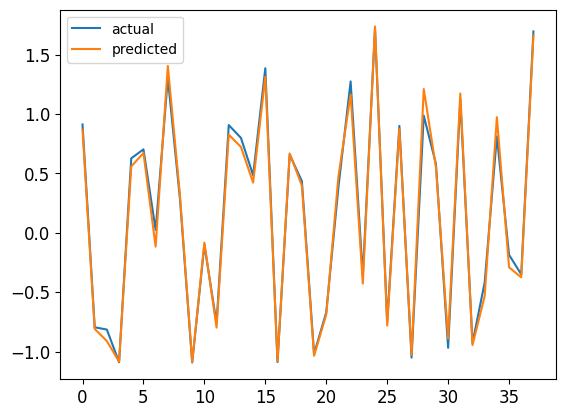

In [37]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [38]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 1s 6ms/step - loss: 0.8470
Epoch 2/30
3/3 [==============================] - 0s 7ms/step - loss: 0.7751
Epoch 3/30
3/3 [==============================] - 0s 8ms/step - loss: 0.7033
Epoch 4/30
3/3 [==============================] - 0s 13ms/step - loss: 0.6298
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 0.5634
Epoch 6/30
3/3 [==============================] - 0s 7ms/step - loss: 0.4942
Epoch 7/30
3/3 [==============================] - 0s 8ms/step - loss: 0.4228
Epoch 8/30
3/3 [==============================] - 0s 7ms/step - loss: 0.3579
Epoch 9/30
3/3 [==============================] - 0s 8ms/step - loss: 0.2937
Epoch 10/30
3/3 [==============================] - 0s 8ms/step - loss: 0.2365
Epoch 11/30
3/3 [==============================] - 0s 8ms/step - loss: 0.1866
Epoch 12/30
3/3 [==============================] - 0s 8ms/step - loss: 0.1481
Epoch 13/30
3/3 [==============================] - 0s 13ms/step - loss: 

In [40]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [41]:
mean_squared_error(y_test, y_pred)

0.009329235805661251

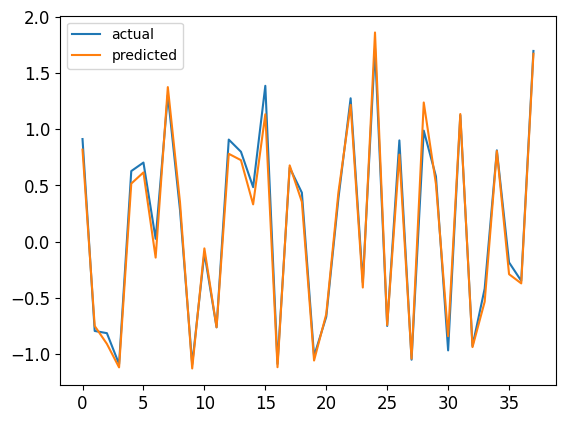

In [42]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [43]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 7s 20ms/step - loss: 0.6861
Epoch 2/30
3/3 [==============================] - 0s 21ms/step - loss: 0.5089
Epoch 3/30
3/3 [==============================] - 0s 28ms/step - loss: 0.3427
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 0.1927
Epoch 5/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0905
Epoch 6/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0375
Epoch 7/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0357
Epoch 8/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0621
Epoch 9/30
3/3 [==============================] - 0s 17ms/step - loss: 0.0636
Epoch 10/30
3/3 [==============================] - 0s 15ms/step - loss: 0.0432
Epoch 11/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0273
Epoch 12/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0234
Epoch 13/30
3/3 [==============================] - 0s 15ms/st

In [45]:
y_pred = model.predict(X_test)

2/2 [==============================] - 2s 5ms/step


In [46]:
mean_squared_error(y_test, y_pred)

0.01810204579470212

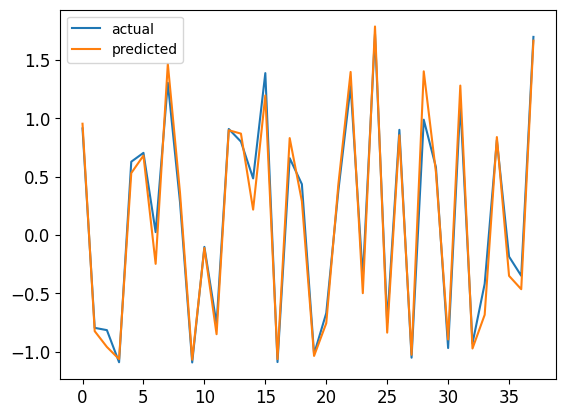

In [47]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# LSTM with many layer

In [48]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 4s 11ms/step - loss: 1.1558
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.9372
Epoch 3/30
3/3 [==============================] - 0s 13ms/step - loss: 0.7346
Epoch 4/30
3/3 [==============================] - 0s 13ms/step - loss: 0.5423
Epoch 5/30
3/3 [==============================] - 0s 14ms/step - loss: 0.3788
Epoch 6/30
3/3 [==============================] - 0s 13ms/step - loss: 0.2277
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 0.1059
Epoch 8/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0404
Epoch 9/30
3/3 [==============================] - 0s 15ms/step - loss: 0.0289
Epoch 10/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0544
Epoch 11/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0678
Epoch 12/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0527
Epoch 13/30
3/3 [==============================] - 0s 14ms/st

In [50]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 5ms/step


In [51]:
mean_squared_error(y_test, y_pred)

0.016844001562547117

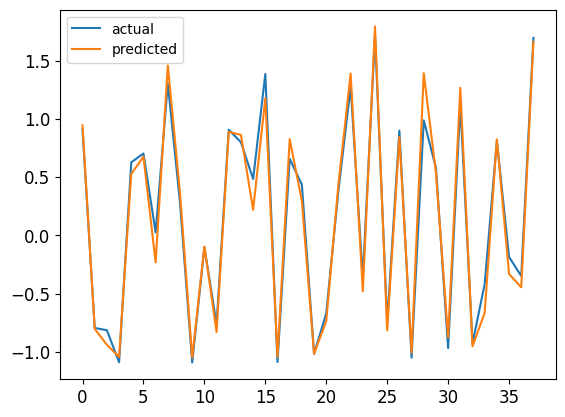

In [52]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [53]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 5s 18ms/step - loss: 0.9095
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.6714
Epoch 3/30
3/3 [==============================] - 0s 13ms/step - loss: 0.5131
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 0.3785
Epoch 5/30
3/3 [==============================] - 0s 18ms/step - loss: 0.2615
Epoch 6/30
3/3 [==============================] - 0s 15ms/step - loss: 0.1664
Epoch 7/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0987
Epoch 8/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0528
Epoch 9/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0300
Epoch 10/30
3/3 [==============================] - 0s 29ms/step - loss: 0.0197
Epoch 11/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0156
Epoch 12/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0136
Epoch 13/30
3/3 [==============================] - 0s 14ms/st

In [55]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [56]:
mean_squared_error(y_test, y_pred)

0.011219560288189621

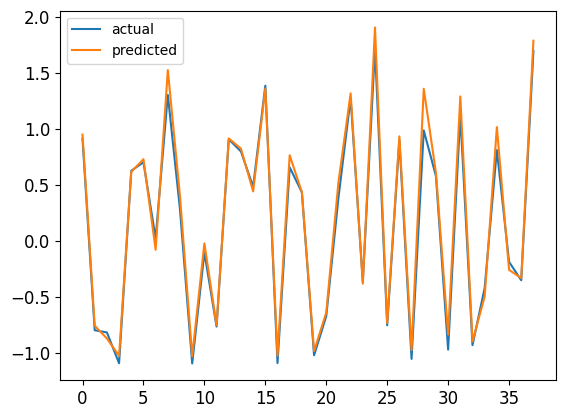

In [57]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

# Conv1D

In [58]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30
3/3 [==============================] - 3s 46ms/step - loss: 1.1564
Epoch 2/30
3/3 [==============================] - 0s 32ms/step - loss: 1.0627
Epoch 3/30
3/3 [==============================] - 0s 31ms/step - loss: 0.9731
Epoch 4/30
3/3 [==============================] - 0s 32ms/step - loss: 0.8730
Epoch 5/30
3/3 [==============================] - 0s 19ms/step - loss: 0.7728
Epoch 6/30
3/3 [==============================] - 0s 15ms/step - loss: 0.6710
Epoch 7/30
3/3 [==============================] - 0s 40ms/step - loss: 0.5635
Epoch 8/30
3/3 [==============================] - 0s 25ms/step - loss: 0.4624
Epoch 9/30
3/3 [==============================] - 0s 17ms/step - loss: 0.3647
Epoch 10/30
3/3 [==============================] - 0s 30ms/step - loss: 0.2836
Epoch 11/30
3/3 [==============================] - 0s 32ms/step - loss: 0.2260
Epoch 12/30
3/3 [==============================] - 0s 30ms/step - loss: 0.1885
Epoch 13/30
3/3 [==============================] - 0s 32ms/st

In [60]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [61]:
mean_squared_error(y_test, y_pred)

0.009505984621644533

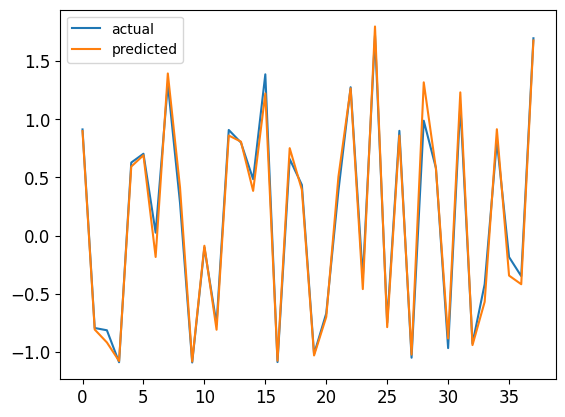

In [62]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

As per the above analysis, we see that the Simple RNN model has less MSE value. Hence it is the best model to be fitted for this data. the MSE value is 0.0046.